In [1]:
# 1. Imports + download
import io
import urllib.request
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve, confusion_matrix
import matplotlib.pyplot as plt

%matplotlib inline

url = "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"
cols = ["age","sex","cp","trestbps","chol","fbs","restecg","thalach","exang","oldpeak","slope","ca","thal","target"]

print("Downloading from:", url)
raw = urllib.request.urlopen(url, timeout=30).read().decode('utf-8')
df = pd.read_csv(io.StringIO(raw), header=None, names=cols, na_values="?")
print("Rows downloaded:", df.shape[0])


Rows downloaded: 303


In [2]:
# 2. Quick inspect
df.head()


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0


In [3]:
# show missing counts and target distribution (before converting)
print("Missing per column:\n", df.isna().sum())
print("\nOriginal target value counts:\n", df["target"].value_counts())


Missing per column:
 age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          4
thal        2
target      0
dtype: int64

Original target value counts:
 target
0    164
1     55
2     36
3     35
4     13
Name: count, dtype: int64


In [4]:
# 3. Preprocess: make binary target, drop missing rows, define features
# Convert target: 0 = no disease, 1 = disease (original 1-4 -> 1)
df["target"] = (df["target"] > 0).astype(int)

# Drop rows with missing values (simple and safe for this sized dataset)
df_clean = df.dropna().reset_index(drop=True)

# Define categorical and numeric features
categorical_features = ["cp", "restecg", "slope", "thal", "ca"]
numeric_features = [c for c in df_clean.columns if c not in categorical_features + ["target"]]

print("Rows after dropna:", df_clean.shape[0])
print("Numeric features:", numeric_features)
print("Categorical features:", categorical_features)
print("\nBinary target counts:\n", df_clean["target"].value_counts())


Rows after dropna: 297
Numeric features: ['age', 'sex', 'trestbps', 'chol', 'fbs', 'thalach', 'exang', 'oldpeak']
Categorical features: ['cp', 'restecg', 'slope', 'thal', 'ca']

Binary target counts:
 target
0    160
1    137
Name: count, dtype: int64


In [6]:
# 4. Build pipeline and train
preprocessor = ColumnTransformer([
    ("num", StandardScaler(), numeric_features),
    ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), categorical_features)
])

clf = Pipeline([
    ("preproc", preprocessor),
    ("logreg", LogisticRegression(solver="liblinear", max_iter=1000, random_state=42))
])

# Split (stratify to keep class ratios)
X = df_clean.drop("target", axis=1)
y = df_clean["target"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

clf.fit(X_train, y_train)
print("Model trained.")


Model trained.


Test accuracy: 0.8533
Test ROC AUC: 0.9300

Classification report:
               precision    recall  f1-score   support

           0       0.85      0.88      0.86        40
           1       0.85      0.83      0.84        35

    accuracy                           0.85        75
   macro avg       0.85      0.85      0.85        75
weighted avg       0.85      0.85      0.85        75

Confusion matrix:
 [[35  5]
 [ 6 29]]


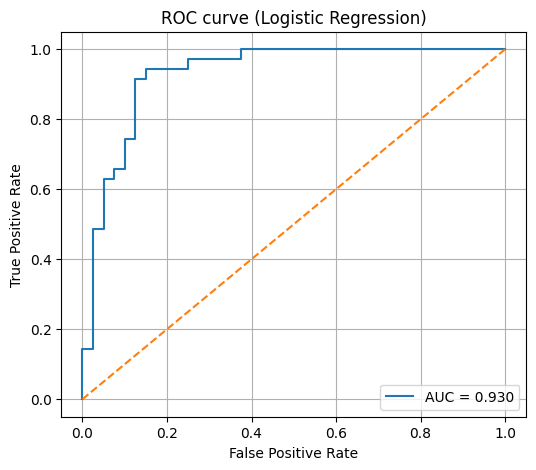

In [7]:
# 5. Evaluate
y_pred = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)[:, 1]

acc = accuracy_score(y_test, y_pred)
roc = roc_auc_score(y_test, y_proba)

print(f"Test accuracy: {acc:.4f}")
print(f"Test ROC AUC: {roc:.4f}\n")
print("Classification report:\n", classification_report(y_test, y_pred))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))

# ROC plot
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {roc:.3f}")
plt.plot([0,1],[0,1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curve (Logistic Regression)")
plt.legend()
plt.grid(True)
plt.show()
